In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader ,random_split
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler
import copy

C:\Users\yoavl\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def create_torch_dataset():
    all_data = []
    scaler = MinMaxScaler()
    columns = ['Input Voltage', 'Output Voltage', 'Tachometer']
    num_rows = 122824
    for i in range(1, 561):
        temp_df = pd.read_csv(f'../PHM09_competition_1/Run_{i}.csv', names=columns, nrows=num_rows)
        normalized_data = scaler.fit_transform(temp_df)
        temp_tensor = torch.tensor(normalized_data, dtype=torch.float32)
        temp_tensor = temp_tensor.unsqueeze(dim=0)  # Adding a channel dimension
        all_data.append(temp_tensor)
    
    all_data_tensor = torch.stack(all_data, dim=0)
    return all_data_tensor

dataset_tensor = create_torch_dataset()

In [3]:
dataset_tensor.shape

torch.Size([560, 1, 122824, 3])

In [4]:
%%time

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, stride=2, padding=1), # Adjusted for 1 input channel
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1), # Adjusted for 1 output channel
            nn.Sigmoid() # Assuming the input data is normalized between 0 and 1
        )

    def forward(self, x):
        # x = self.encoder(x)
        # x = self.decoder(x)
        return self.decoder(self.encoder(x))


def train_model(model, train_dataset, val_dataset, n_epochs):
    best_loss = float('inf')
    # best_model_wts = copy.deepcopy(model.state_dict())
    history = {'train': [], 'val': []}
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()
    loss_fn = nn.L1Loss(reduction='sum')
    train_loss = 0

    for epoch in range(1, n_epochs + 1):
        model = model.train()
        train_loss = []
        for seq_true in train_dataset:
            optimizer.zero_grad()
            seq_pred = model(seq_true)
            loss = loss_fn(seq_pred, seq_true)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        # Eval loop 
        val_loss = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:
                seq_pred = model(seq_true)
                loss = loss_fn(seq_pred,seq_true)
                val_loss.append(loss.item())
            
        avg_train_loss = sum(train_loss) / len(train_loss)
        avg_val_loss = sum(val_loss) / len(val_loss)
        history['train'].append(avg_train_loss)
        history['val'].append(avg_val_loss)

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            # best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {avg_train_loss} val loss {avg_val_loss}')
        # model.load_state_dict(best_model_wts)
    
    return model, history
    
# Prepare DataLoaders
dataset_tensor = dataset_tensor.view(560, 1, -1)  # Reshape tensor
train_size = int(0.8 * len(dataset_tensor))
val_size = len(dataset_tensor) - train_size
train_dataset, val_dataset = random_split(dataset_tensor, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)


model, history = train_model(Autoencoder() ,train_dataset, val_dataset, n_epochs=15)

Epoch 1: train loss 19253.90277317592 val loss 8315.61745779855
Epoch 2: train loss 6781.392303466797 val loss 5343.426062447684
Epoch 3: train loss 5114.375869750977 val loss 5072.595467703683
Epoch 4: train loss 4320.109405517578 val loss 4654.436525617327
Epoch 5: train loss 3738.915455409459 val loss 3272.9041333879745
Epoch 6: train loss 3364.825637817383 val loss 3356.017333984375
Epoch 7: train loss 3200.708116258894 val loss 3022.8571428571427
Epoch 8: train loss 3071.361956187657 val loss 2951.8286743164062
Epoch 9: train loss 2965.20302936009 val loss 3262.6512625558034
Epoch 10: train loss 3008.110984529768 val loss 3290.0622035435267
Epoch 11: train loss 2864.2097571236745 val loss 2827.5806001935684
Epoch 12: train loss 2789.8813765389577 val loss 2791.406557355608
Epoch 13: train loss 2799.9069791521347 val loss 3097.534731183733
Epoch 14: train loss 2797.8524319784983 val loss 2738.666452680315
Epoch 15: train loss 2675.32606615339 val loss 2532.8520344325475
CPU times: 

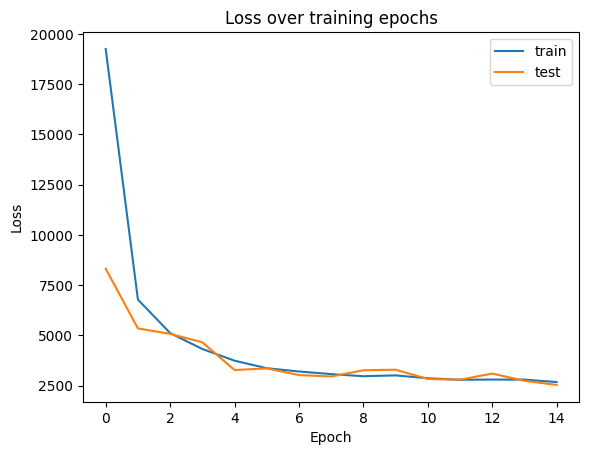

In [5]:
# This plot should help to choose the THRESHOLD
ax = plt.figure().gca()
ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [6]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum')
  # criterion = nn.MSELoss()
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true
      seq_pred = model(seq_true)
      loss = criterion(seq_pred, seq_true)
      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
      result_df = pd.DataFrame({
        'Run_id': range(1, len(predictions) + 1),
        'Condition': predictions,
        'Loss':losses,
    })
  return result_df , predictions, losses

df_pred ,predictions, losses = predict(model , dataset_tensor)
df_pred

,Run_id,Condition,Loss
0,1,"[0.25040457, 0.734908, 0.95790565, 0.3375528, ...",3020.398438
1,2,"[0.25338888, 0.6336545, 0.27607408, 0.2878816,...",3475.364746
2,3,"[0.25768724, 0.71836257, 0.9571178, 0.34636393...",2135.639648
3,4,"[0.32150313, 0.61006594, 0.9483655, 0.45850983...",2261.490967
4,5,"[0.2776234, 0.6233317, 0.27586418, 0.36635566,...",1888.725098
...,...,...,...
555,556,"[0.2297352, 0.6880291, 0.95589286, 0.27791315,...",2388.073730
556,557,"[0.26312688, 0.7343303, 0.2701208, 0.37042102,...",3118.228760
557,558,"[0.23589714, 0.6610354, 0.9520817, 0.305444, 0...",2136.425537
558,559,"[0.22448881, 0.67442036, 0.25062075, 0.1975732...",3015.775635


C:\Users\yoavl\AppData\Local\Temp\ipykernel_20708\2953814399.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=50, kde=True);


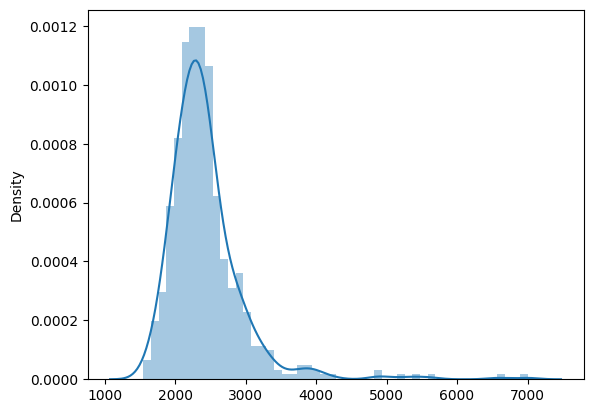

In [9]:
sns.distplot(losses, bins=50, kde=True);

In [10]:
THRESHOLD = 5000
correct = sum(l <= THRESHOLD for l in losses)
correct

555

In [14]:

anomaly = df_pred[df_pred['Loss'] >= THRESHOLD].index
anomaly

Index([160, 207, 282, 310, 431], dtype='int64')

In [ ]:
result_df['Condition'].value_counts()

In [ ]:
anomaly = result_df[result_df['Condition'] == True].index
anomaly_list = list(anomaly)
len()

In [ ]:
def append_anomalies_to_csv(anomaly_list, file_name):
    """
    Appends the given anomaly list to an existing CSV file, or creates a new one if it doesn't exist.
    Also adds a column indicating the length of the anomaly list.
    
    :param anomaly_list: List of anomaly indices.
    :param file_name: Name of the CSV file to append to or create.
    """
    try:
        existing_df = pd.read_csv(file_name)
    except FileNotFoundError:
        existing_df = pd.DataFrame(columns=['Index', 'Anomaly', 'Length'])
    
    # Create a new DataFrame from the anomaly list
    new_data = pd.DataFrame({'Anomaly': [anomaly_list], 'Length': [len(anomaly_list)]})
    new_data['Index'] = existing_df.shape[0] + 1

    # Append the new data to the existing DataFrame
    updated_df = pd.concat([existing_df, new_data], ignore_index=True)

    # Save the updated DataFrame to the CSV file
    updated_df.to_csv(file_name, index=False)

append_anomalies_to_csv(anomaly_list,'anomaly.csv')

df = pd.read_csv('anomaly.csv')
df

In [ ]:
# common_elements = list(set(a) & set(anomaly_list))
# common_elements
from collections import Counter
from ast import literal_eval
def plot_anomaly_frequency_sorted(df):
    # Extracting all numbers from the 'Anomaly' lists and flattening them into a single list
    all_anomalies = [num for sublist in df['Anomaly'].apply(literal_eval) for num in sublist]
    anomaly_counts = Counter(all_anomalies)
    # Sorting the counts
    sorted_anomaly_counts = dict(sorted(anomaly_counts.items()))
    plt.figure(figsize=(15, 6))
    plt.scatter(sorted_anomaly_counts.keys(), sorted_anomaly_counts.values())
    plt.xlabel('Anomaly Number')
    plt.ylabel('Frequency')
    plt.title('Sorted Frequency of Each Number in Anomaly Lists')
    plt.show()

plot_anomaly_frequency_sorted(df)

In [ ]:
from torchinfo import summary 
summary(model)